In [ ]:
# imports and config
import os
import random
from pathlib import Path
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, models
from PIL import Image

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix,
                             roc_curve, auc)

import itertools

# Reproductibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Config
ROOT = "C:/Users/MSC055/Desktop/Sabrina/CSE754/Gallbladder DIsease/Gallbladder DIsease"  # folder with subfolders per class
SAVE_DIR = "C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl"
os.makedirs(SAVE_DIR, exist_ok=True)

# SimCLR pretrain config
SIMCLR_EPOCHS = 50
SIMCLR_BS = 64
SIMCLR_LR = 1e-3
PROJ_DIM = 128
TEMPERATURE = 0.5

# Fine-tune config
FINETUNE_EPOCHS = 50
FINETUNE_BS = 32
FINETUNE_LR = 5e-5

IMAGE_SIZE = 224
#NUM_WORKERS = 4


Device: cuda


In [2]:
import os

data_dir = "C:/Users/MSC055/Desktop/Sabrina/CSE754/Gallbladder DIsease/Gallbladder DIsease"
classes = os.listdir(data_dir)
for cls in classes:
    print(f"Class: {cls}, Number of Images: {len(os.listdir(os.path.join(data_dir, cls)))}")

Class: 1Gallstones, Number of Images: 1326
Class: 2Abdomen and retroperitoneum, Number of Images: 1170
Class: 3cholecystitis, Number of Images: 1146
Class: 4Membranous and gangrenous cholecystitis, Number of Images: 1224
Class: 5Perforation, Number of Images: 1062
Class: 6Polyps and cholesterol crystals, Number of Images: 1020
Class: 7Adenomyomatosis, Number of Images: 1164
Class: 8Carcinoma, Number of Images: 1590
Class: 9Various causes of gallbladder wall thickening, Number of Images: 990


In [3]:
from PIL import Image

image_sizes = []
for cls in classes:
    for img_file in os.listdir(os.path.join(data_dir, cls)):
        img = Image.open(os.path.join(data_dir, cls, img_file))
        image_sizes.append(img.size)

print(set(image_sizes))  # Unique image sizes

{(2400, 1800), (1170, 876), (900, 1200), (1200, 900)}


In [4]:
corrupted_images = []
for cls in classes:
    for img_file in os.listdir(os.path.join(data_dir, cls)):
        try:
            img = Image.open(os.path.join(data_dir, cls, img_file))
            img.verify()  # Check for corruption
        except (IOError, SyntaxError):
            corrupted_images.append(img_file)

print("Corrupted Images:", corrupted_images)

Corrupted Images: []


C:\Users\MSC055\AppData\Local\Temp\ipykernel_16372\1724826377.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=class_counts, palette = 'Set1')


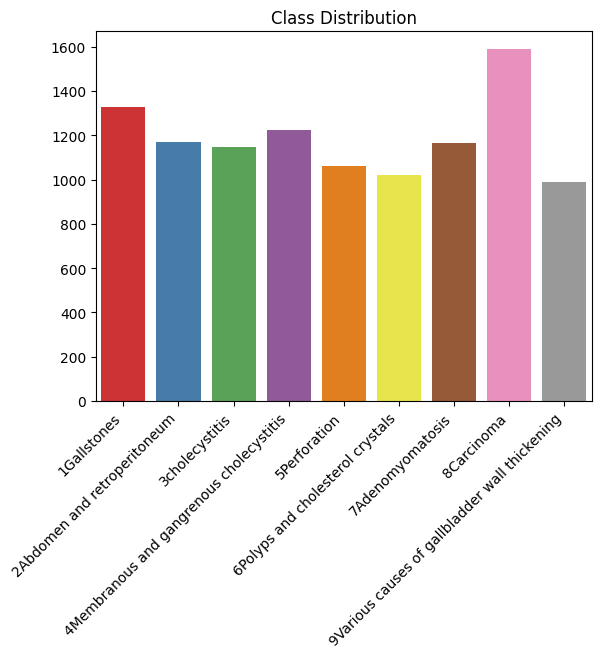

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = [len(os.listdir(os.path.join(data_dir, cls))) for cls in classes]
sns.barplot(x=classes, y=class_counts, palette = 'Set1')
plt.xticks(rotation=45, ha='right')
plt.title("Class Distribution")
plt.show()

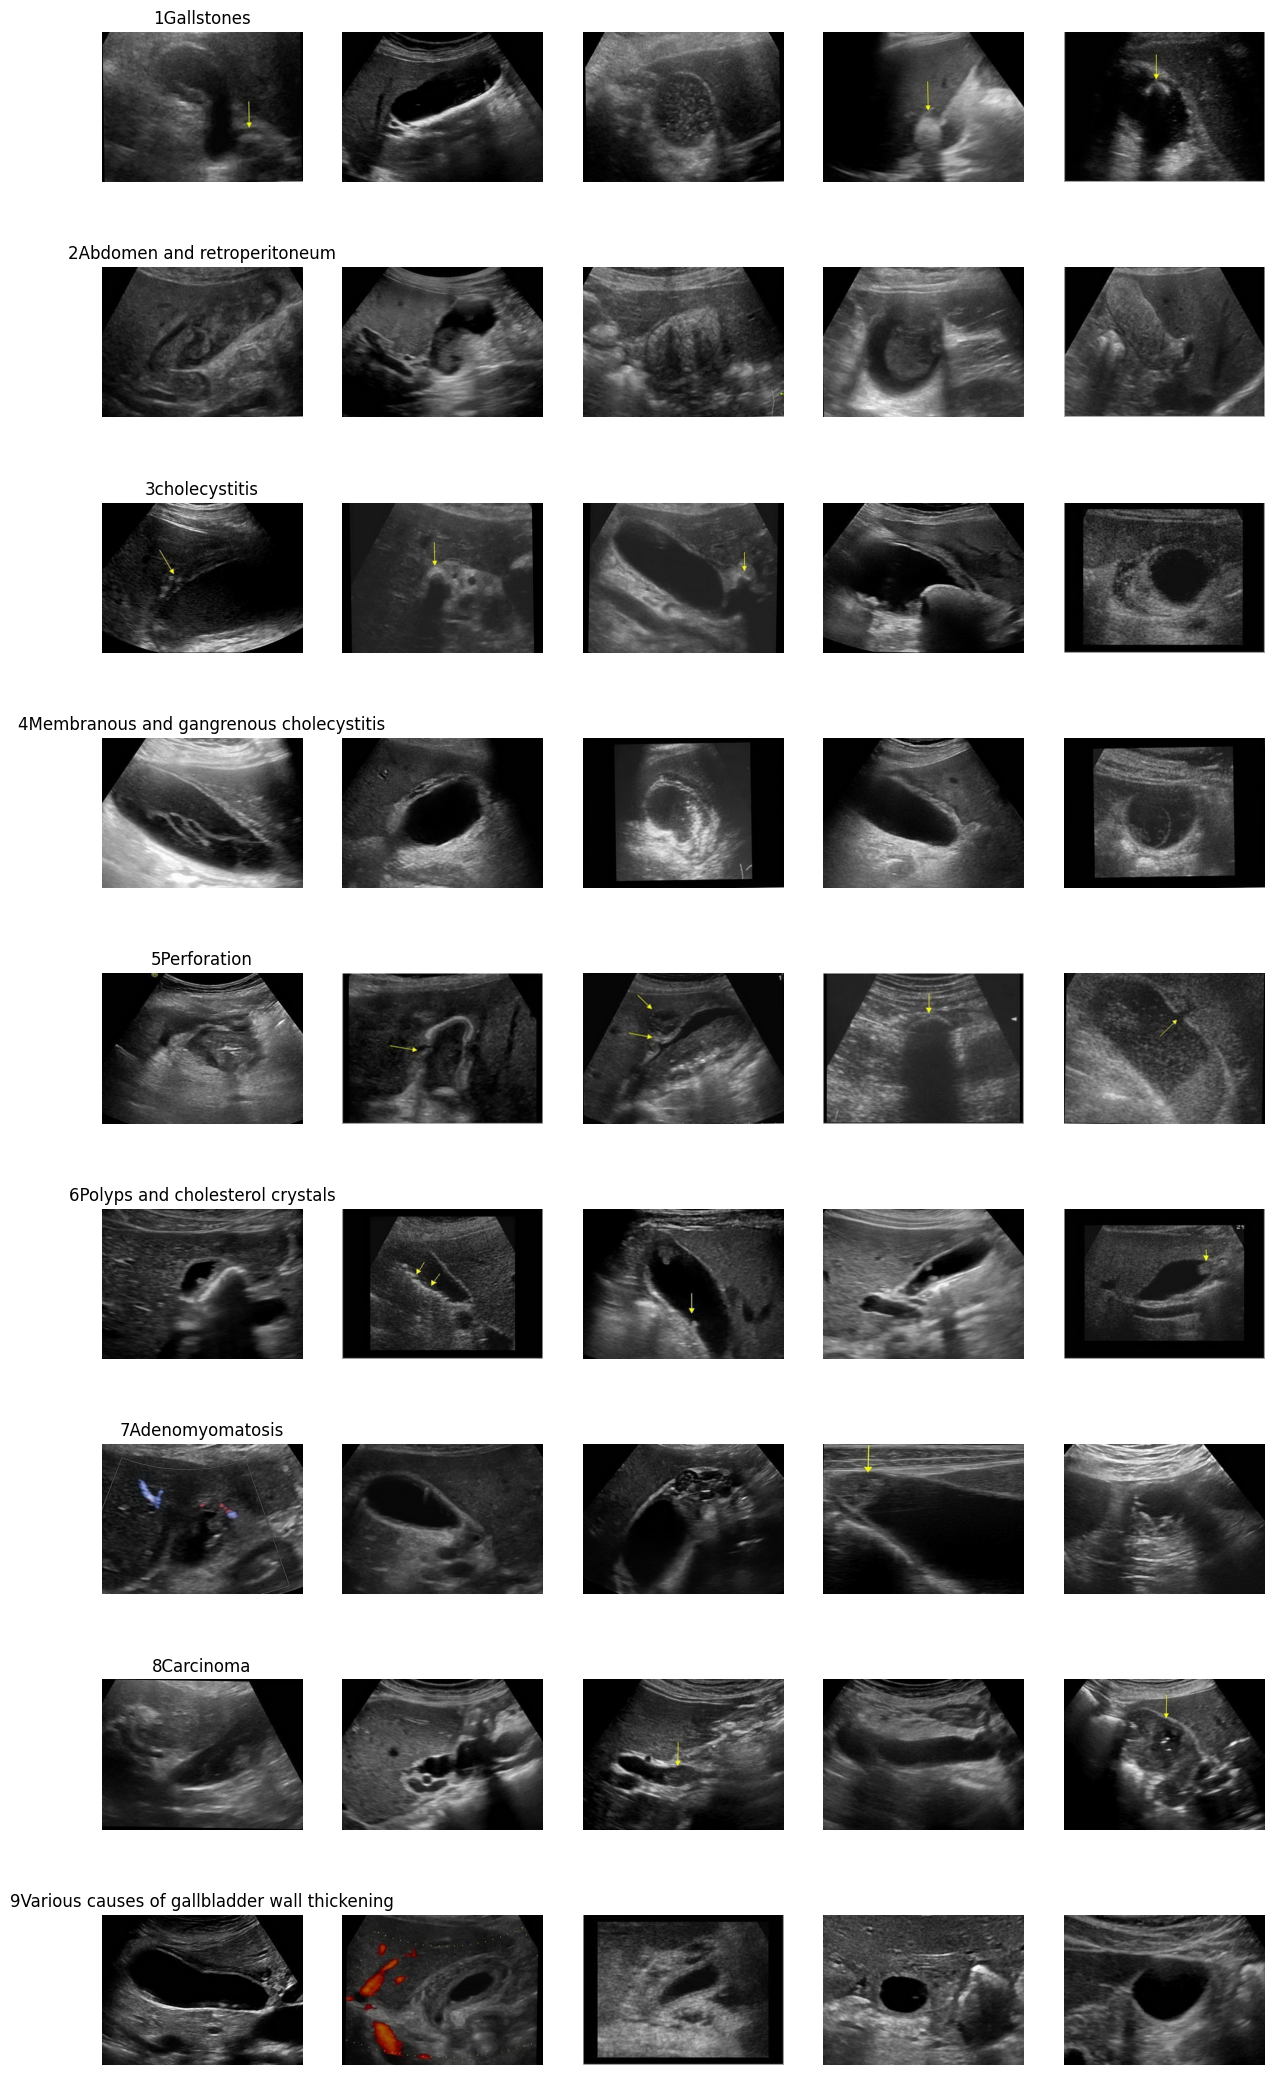

In [6]:
import random
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(classes), 5, figsize=(15, len(classes) * 3))
for i, cls in enumerate(classes):
    class_dir = os.path.join(data_dir, cls)
    for j in range(5):
        img_path = os.path.join(class_dir, random.choice(os.listdir(class_dir)))
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 0:
            axes[i, j].set_title(cls)
plt.show()

In [ ]:
# build file lists and do stratified split
root = Path(ROOT)
assert root.exists(), f"{ROOT} not found"

# collect image paths and class labels (subfolders)
image_paths = []
image_labels = []
class_names = sorted([d.name for d in root.iterdir() if d.is_dir()])
class_to_idx = {c:i for i,c in enumerate(class_names)}
print("Detected classes:", class_names)

for cls in class_names:
    folder = root / cls
    for p in folder.glob("*"):
        if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]:
            image_paths.append(str(p))
            image_labels.append(class_to_idx[cls])

print("Total images:", len(image_paths))
print("Per-class counts:", Counter(image_labels))

# Stratified split: train 80%, val 10%, test 10%
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, image_labels, test_size=0.20, stratify=image_labels, random_state=SEED
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=SEED
)

print("Split sizes -> train:", len(train_paths), "val:", len(val_paths), "test:", len(test_paths))

# Convert class indices back to class names for readability
idx_to_class = {v: k for k, v in class_to_idx.items()}

def print_class_counts(labels, name):
    counts = Counter(labels)
    print(f"\n{name} set class distribution:")
    for cls_idx, count in counts.items():
        print(f"  {idx_to_class[cls_idx]} ({cls_idx}): {count}")
    print("Total:", sum(counts.values()))

# Print distributions
print_class_counts(train_labels, "Train")
print_class_counts(val_labels, "Val")
print_class_counts(test_labels, "Test")


Detected classes: ['1Gallstones', '2Abdomen and retroperitoneum', '3cholecystitis', '4Membranous and gangrenous cholecystitis', '5Perforation', '6Polyps and cholesterol crystals', '7Adenomyomatosis', '8Carcinoma', '9Various causes of gallbladder wall thickening']
Total images: 10692
Per-class counts: Counter({7: 1590, 0: 1326, 3: 1224, 1: 1170, 6: 1164, 2: 1146, 4: 1062, 5: 1020, 8: 990})
Split sizes -> train: 8553 val: 1069 test: 1070

Train set class distribution:
  2Abdomen and retroperitoneum (1): 936
  7Adenomyomatosis (6): 931
  1Gallstones (0): 1061
  5Perforation (4): 849
  4Membranous and gangrenous cholecystitis (3): 979
  8Carcinoma (7): 1272
  6Polyps and cholesterol crystals (5): 816
  9Various causes of gallbladder wall thickening (8): 792
  3cholecystitis (2): 917
Total: 8553

Val set class distribution:
  1Gallstones (0): 132
  8Carcinoma (7): 159
  3cholecystitis (2): 115
  7Adenomyomatosis (6): 116
  4Membranous and gangrenous cholecystitis (3): 122
  2Abdomen and ret

In [ ]:
# Transforms and Datasets

# SimCLR augmentations (two views)
simclr_transforms = T.Compose([
    T.RandomResizedCrop(IMAGE_SIZE, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomApply([T.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=int(0.1*IMAGE_SIZE)//2*2+1, sigma=(0.1, 2.0)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# For fine-tuning (train/val/test)
train_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
eval_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Datasets
class SimCLRDataset(Dataset):
    """Returns two augmented views for SimCLR pretraining."""
    def __init__(self, paths, transform):
        self.paths = list(paths)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        x1 = self.transform(img)
        x2 = self.transform(img)
        return x1, x2

class ImageDataset(Dataset):
    """Standard labeled dataset used for fine-tuning / evaluation."""
    def __init__(self, paths, labels, transform):
        self.paths = list(paths)
        self.labels = list(labels)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# Create loaders
simclr_dataset = SimCLRDataset(train_paths, simclr_transforms)
simclr_loader = DataLoader(simclr_dataset, batch_size=SIMCLR_BS, shuffle=True, drop_last=True)

ft_train_dataset = ImageDataset(train_paths, train_labels, train_transform)
ft_val_dataset   = ImageDataset(val_paths, val_labels, eval_transform)
ft_test_dataset  = ImageDataset(test_paths, test_labels, eval_transform)

train_loader = DataLoader(ft_train_dataset, batch_size=FINETUNE_BS, shuffle=True)
val_loader   = DataLoader(ft_val_dataset,   batch_size=FINETUNE_BS, shuffle=False)
test_loader  = DataLoader(ft_test_dataset,  batch_size=FINETUNE_BS, shuffle=False)

print("SimCLR dataset size:", len(simclr_dataset), "\nSimCLR loader batches:", len(simclr_loader))
print("Fine-tune train sizes:", len(ft_train_dataset), "\nFine-tune val sizes:", len(ft_val_dataset), "\nFine-tune test sizes:", len(ft_test_dataset))


SimCLR dataset size: 8553 
SimCLR loader batches: 133
Fine-tune train sizes: 8553 
Fine-tune val sizes: 1069 
Fine-tune test sizes: 1070


In [ ]:
# SimCLR model and loss

class ResNet50Encoder(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        res = models.resnet50(pretrained=pretrained)
        # remove fc and avgpool
        self.features = nn.Sequential(*list(res.children())[:-2])  # outputs feature map (B,2048,H',W')
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.out_dim = 2048

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return x

class SimCLRModel(nn.Module):
    def __init__(self, base_encoder, proj_dim=128):
        super().__init__()
        self.encoder = base_encoder
        feat_dim = self.encoder.out_dim
        # projection head: 2-layer MLP as in SimCLR
        self.projector = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.ReLU(inplace=True),
            nn.Linear(feat_dim, proj_dim)
        )

    def forward(self, x):
        h = self.encoder(x)       # representation
        z = self.projector(h)     # projection
        z = F.normalize(z, dim=1)
        return h, z

# NT-Xent loss
def nt_xent_loss(z_i, z_j, temperature=0.5):
    """
    z_i, z_j : tensors of shape [B, D] — normalized (unit vectors)
    Returns: scalar loss
    """
    batch_size = z_i.shape[0]
    z = torch.cat([z_i, z_j], dim=0)  # 2B x D
    # Compute cosine similarity matrix
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)  # 2B x 2B
    # divide by temperature
    sim = sim / temperature

    # mask to remove similarity with itself
    labels = torch.arange(batch_size).to(z.device)
    labels = torch.cat([labels, labels], dim=0)

    # create mask to remove diagonal elements
    mask = (~torch.eye(2*batch_size, dtype=torch.bool)).to(z.device)

    # numerator: exp(similarity between positive pairs)
    # for each i in [0..B-1], positive pair is (i, i+B) and vice-versa
    exp_sim = torch.exp(sim) * mask.float()

    # denominator: sum over all except itself
    denom = exp_sim.sum(dim=1)

    # positive similarities
    pos_sim = torch.exp(F.cosine_similarity(z_i, z_j) / temperature)
    pos_sim = torch.cat([pos_sim, pos_sim], dim=0)

    loss = -torch.log(pos_sim / denom)
    return loss.mean()

# Build SimCLR model
base_enc = ResNet50Encoder(pretrained=False)
simclr = SimCLRModel(base_enc, proj_dim=PROJ_DIM).to(device)


c:\Users\MSC055\.conda\envs\pytorch2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MSC055\.conda\envs\pytorch2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


SimCLR Epoch 1/50: 100%|██████████| 133/133 [03:55<00:00,  1.77s/it, loss=4.71]


SimCLR Epoch 1 completed. SimCLR Contrastive Loss: 4.711405


SimCLR Epoch 2/50: 100%|██████████| 133/133 [03:39<00:00,  1.65s/it, loss=4.44]


SimCLR Epoch 2 completed. SimCLR Contrastive Loss: 4.443207


SimCLR Epoch 3/50: 100%|██████████| 133/133 [03:40<00:00,  1.66s/it, loss=4.32]


SimCLR Epoch 3 completed. SimCLR Contrastive Loss: 4.317116


SimCLR Epoch 4/50: 100%|██████████| 133/133 [03:40<00:00,  1.66s/it, loss=4.08]


SimCLR Epoch 4 completed. SimCLR Contrastive Loss: 4.084430


SimCLR Epoch 5/50: 100%|██████████| 133/133 [03:47<00:00,  1.71s/it, loss=3.98]


SimCLR Epoch 5 completed. SimCLR Contrastive Loss: 3.977150


SimCLR Epoch 6/50: 100%|██████████| 133/133 [03:53<00:00,  1.75s/it, loss=3.93]


SimCLR Epoch 6 completed. SimCLR Contrastive Loss: 3.930017


SimCLR Epoch 7/50: 100%|██████████| 133/133 [03:45<00:00,  1.69s/it, loss=3.88]


SimCLR Epoch 7 completed. SimCLR Contrastive Loss: 3.883386


SimCLR Epoch 8/50: 100%|██████████| 133/133 [03:47<00:00,  1.71s/it, loss=3.84]


SimCLR Epoch 8 completed. SimCLR Contrastive Loss: 3.836589


SimCLR Epoch 9/50: 100%|██████████| 133/133 [03:47<00:00,  1.71s/it, loss=3.8]


SimCLR Epoch 9 completed. SimCLR Contrastive Loss: 3.800451


SimCLR Epoch 10/50: 100%|██████████| 133/133 [03:43<00:00,  1.68s/it, loss=3.75]


SimCLR Epoch 10 completed. SimCLR Contrastive Loss: 3.754264


SimCLR Epoch 11/50: 100%|██████████| 133/133 [03:43<00:00,  1.68s/it, loss=3.7] 


SimCLR Epoch 11 completed. SimCLR Contrastive Loss: 3.701082


SimCLR Epoch 12/50: 100%|██████████| 133/133 [03:48<00:00,  1.71s/it, loss=3.67]


SimCLR Epoch 12 completed. SimCLR Contrastive Loss: 3.671146


SimCLR Epoch 13/50: 100%|██████████| 133/133 [03:45<00:00,  1.70s/it, loss=3.63]


SimCLR Epoch 13 completed. SimCLR Contrastive Loss: 3.627815


SimCLR Epoch 14/50: 100%|██████████| 133/133 [03:47<00:00,  1.71s/it, loss=3.61]


SimCLR Epoch 14 completed. SimCLR Contrastive Loss: 3.605066


SimCLR Epoch 15/50: 100%|██████████| 133/133 [03:46<00:00,  1.70s/it, loss=3.56]


SimCLR Epoch 15 completed. SimCLR Contrastive Loss: 3.560347


SimCLR Epoch 16/50: 100%|██████████| 133/133 [03:45<00:00,  1.70s/it, loss=3.54]


SimCLR Epoch 16 completed. SimCLR Contrastive Loss: 3.538930


SimCLR Epoch 17/50: 100%|██████████| 133/133 [03:46<00:00,  1.70s/it, loss=3.52]


SimCLR Epoch 17 completed. SimCLR Contrastive Loss: 3.523458


SimCLR Epoch 18/50: 100%|██████████| 133/133 [03:45<00:00,  1.70s/it, loss=3.5] 


SimCLR Epoch 18 completed. SimCLR Contrastive Loss: 3.503950


SimCLR Epoch 19/50: 100%|██████████| 133/133 [03:46<00:00,  1.70s/it, loss=3.5] 


SimCLR Epoch 19 completed. SimCLR Contrastive Loss: 3.498984


SimCLR Epoch 20/50: 100%|██████████| 133/133 [03:45<00:00,  1.70s/it, loss=3.48]


SimCLR Epoch 20 completed. SimCLR Contrastive Loss: 3.480116


SimCLR Epoch 21/50: 100%|██████████| 133/133 [03:50<00:00,  1.73s/it, loss=3.46]


SimCLR Epoch 21 completed. SimCLR Contrastive Loss: 3.459103


SimCLR Epoch 22/50: 100%|██████████| 133/133 [03:50<00:00,  1.73s/it, loss=3.45]


SimCLR Epoch 22 completed. SimCLR Contrastive Loss: 3.447812


SimCLR Epoch 23/50: 100%|██████████| 133/133 [03:47<00:00,  1.71s/it, loss=3.44]


SimCLR Epoch 23 completed. SimCLR Contrastive Loss: 3.437200


SimCLR Epoch 24/50: 100%|██████████| 133/133 [03:46<00:00,  1.70s/it, loss=3.43]


SimCLR Epoch 24 completed. SimCLR Contrastive Loss: 3.425572


SimCLR Epoch 25/50: 100%|██████████| 133/133 [03:49<00:00,  1.72s/it, loss=3.41]


SimCLR Epoch 25 completed. SimCLR Contrastive Loss: 3.408499


SimCLR Epoch 26/50: 100%|██████████| 133/133 [03:47<00:00,  1.71s/it, loss=3.4] 


SimCLR Epoch 26 completed. SimCLR Contrastive Loss: 3.396105


SimCLR Epoch 27/50: 100%|██████████| 133/133 [03:46<00:00,  1.70s/it, loss=3.38]


SimCLR Epoch 27 completed. SimCLR Contrastive Loss: 3.383061


SimCLR Epoch 28/50: 100%|██████████| 133/133 [03:48<00:00,  1.72s/it, loss=3.37]


SimCLR Epoch 28 completed. SimCLR Contrastive Loss: 3.371234


SimCLR Epoch 29/50: 100%|██████████| 133/133 [03:47<00:00,  1.71s/it, loss=3.37]


SimCLR Epoch 29 completed. SimCLR Contrastive Loss: 3.365608


SimCLR Epoch 30/50: 100%|██████████| 133/133 [03:47<00:00,  1.71s/it, loss=3.36]


SimCLR Epoch 30 completed. SimCLR Contrastive Loss: 3.355954


SimCLR Epoch 31/50: 100%|██████████| 133/133 [03:48<00:00,  1.71s/it, loss=3.34]


SimCLR Epoch 31 completed. SimCLR Contrastive Loss: 3.342389


SimCLR Epoch 32/50: 100%|██████████| 133/133 [03:48<00:00,  1.72s/it, loss=3.33]


SimCLR Epoch 32 completed. SimCLR Contrastive Loss: 3.328568


SimCLR Epoch 33/50: 100%|██████████| 133/133 [03:49<00:00,  1.73s/it, loss=3.34]


SimCLR Epoch 33 completed. SimCLR Contrastive Loss: 3.336509


SimCLR Epoch 34/50: 100%|██████████| 133/133 [03:46<00:00,  1.70s/it, loss=3.32]


SimCLR Epoch 34 completed. SimCLR Contrastive Loss: 3.315538


SimCLR Epoch 35/50: 100%|██████████| 133/133 [03:46<00:00,  1.70s/it, loss=3.31]


SimCLR Epoch 35 completed. SimCLR Contrastive Loss: 3.314652


SimCLR Epoch 36/50: 100%|██████████| 133/133 [03:48<00:00,  1.72s/it, loss=3.31]


SimCLR Epoch 36 completed. SimCLR Contrastive Loss: 3.310916


SimCLR Epoch 37/50: 100%|██████████| 133/133 [03:54<00:00,  1.76s/it, loss=3.31]


SimCLR Epoch 37 completed. SimCLR Contrastive Loss: 3.311128


SimCLR Epoch 38/50: 100%|██████████| 133/133 [03:47<00:00,  1.71s/it, loss=3.29]


SimCLR Epoch 38 completed. SimCLR Contrastive Loss: 3.288364


SimCLR Epoch 39/50: 100%|██████████| 133/133 [03:46<00:00,  1.70s/it, loss=3.29]


SimCLR Epoch 39 completed. SimCLR Contrastive Loss: 3.288269


SimCLR Epoch 40/50: 100%|██████████| 133/133 [03:46<00:00,  1.71s/it, loss=3.28]


SimCLR Epoch 40 completed. SimCLR Contrastive Loss: 3.283841


SimCLR Epoch 41/50: 100%|██████████| 133/133 [03:44<00:00,  1.69s/it, loss=3.27]


SimCLR Epoch 41 completed. SimCLR Contrastive Loss: 3.273393


SimCLR Epoch 42/50: 100%|██████████| 133/133 [03:33<00:00,  1.60s/it, loss=3.27]


SimCLR Epoch 42 completed. SimCLR Contrastive Loss: 3.268095


SimCLR Epoch 43/50: 100%|██████████| 133/133 [03:34<00:00,  1.61s/it, loss=3.26]


SimCLR Epoch 43 completed. SimCLR Contrastive Loss: 3.261558


SimCLR Epoch 44/50: 100%|██████████| 133/133 [03:35<00:00,  1.62s/it, loss=3.26]


SimCLR Epoch 44 completed. SimCLR Contrastive Loss: 3.257395


SimCLR Epoch 45/50: 100%|██████████| 133/133 [03:27<00:00,  1.56s/it, loss=3.26]


SimCLR Epoch 45 completed. SimCLR Contrastive Loss: 3.256331


SimCLR Epoch 46/50: 100%|██████████| 133/133 [03:27<00:00,  1.56s/it, loss=3.25]


SimCLR Epoch 46 completed. SimCLR Contrastive Loss: 3.246313


SimCLR Epoch 47/50: 100%|██████████| 133/133 [03:24<00:00,  1.54s/it, loss=3.24]


SimCLR Epoch 47 completed. SimCLR Contrastive Loss: 3.241160


SimCLR Epoch 48/50: 100%|██████████| 133/133 [03:25<00:00,  1.55s/it, loss=3.24]


SimCLR Epoch 48 completed. SimCLR Contrastive Loss: 3.238017


SimCLR Epoch 49/50: 100%|██████████| 133/133 [03:30<00:00,  1.58s/it, loss=3.23]


SimCLR Epoch 49 completed. SimCLR Contrastive Loss: 3.232914


SimCLR Epoch 50/50: 100%|██████████| 133/133 [03:32<00:00,  1.60s/it, loss=3.23]


SimCLR Epoch 50 completed. SimCLR Contrastive Loss: 3.233048
SimCLR weights saved to: C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\simclr_pretrain_weights.pth


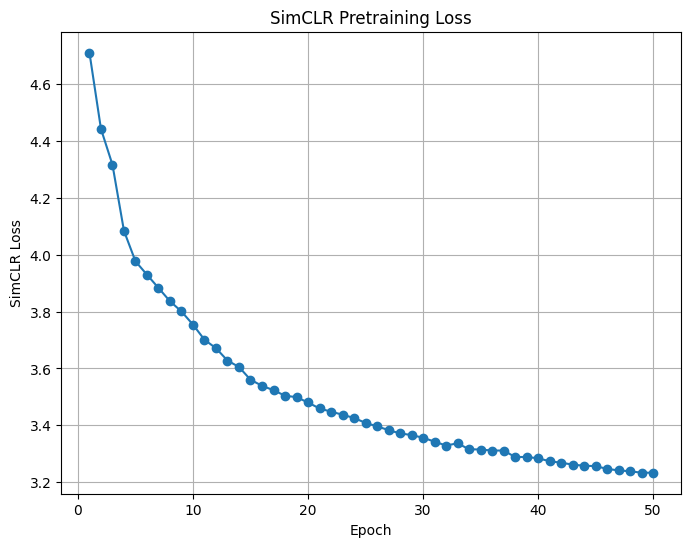

In [ ]:
# SimCLR pretraining loop
optimizer_simclr = torch.optim.AdamW(simclr.parameters(), lr=SIMCLR_LR, weight_decay=1e-4)
scheduler = None 

simclr_losses = []

for epoch in range(1, SIMCLR_EPOCHS+1):
    simclr.train()
    running_loss = 0.0
    iters = 0
    pbar = tqdm(simclr_loader, desc=f"SimCLR Epoch {epoch}/{SIMCLR_EPOCHS}")
    for x1, x2 in pbar:
        x1 = x1.to(device); x2 = x2.to(device)
        optimizer_simclr.zero_grad()
        _, z1 = simclr(x1)
        _, z2 = simclr(x2)
        loss = nt_xent_loss(z1, z2, temperature=TEMPERATURE)
        loss.backward()
        optimizer_simclr.step()

        running_loss += loss.item()
        iters += 1
        pbar.set_postfix(loss=running_loss/iters)

    epoch_loss = running_loss / max(1, iters)
    simclr_losses.append(epoch_loss)
    print(f"SimCLR Epoch {epoch} completed. SimCLR Contrastive Loss: {epoch_loss:.6f}")

    #  Save overall/final weights after all epochs 
    simclr_pretrain_weights_path = os.path.join(SAVE_DIR, "simclr_pretrain_weights.pth")
    torch.save({
        'epoch': SIMCLR_EPOCHS,
        'simclr_state_dict': simclr.state_dict(),
        'optimizer': optimizer_simclr.state_dict()
    }, simclr_pretrain_weights_path)

print(f"SimCLR weights saved to: {simclr_pretrain_weights_path}")

# plot simclr loss curve
plt.figure(figsize=(8,6))
plt.plot(range(1, len(simclr_losses)+1), simclr_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("SimCLR Loss")
plt.title("SimCLR Pretraining Loss")
plt.grid(True)
plt.show()


In [ ]:
# Build fine-tuning model using the pretrained encoder
class FineTuneResNet50(nn.Module):
    def __init__(self, simclr_model, num_classes, finetune_from_simclr=True):
        super().__init__()
        # create a fresh resnet50 and load encoder weights from simclr
        res = models.resnet50(pretrained=False)

    
        self.backbone = res
        self.backbone.load_state_dict(simclr_model.encoder.state_dict(), strict=False)  # copy weights

        # classifier head
        feat_dim = simclr.encoder.out_dim
        self.backbone.fc = nn.Identity()  # we will add our own head
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(feat_dim),
            nn.Linear(feat_dim, feat_dim // 2),
            nn.ReLU(inplace=True),
            nn.Linear(feat_dim // 2, num_classes)
        )

        print("Loaded SimCLR encoder weights into ResNet50 backbone.")


    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

num_classes = len(class_names)
finetune_model = FineTuneResNet50(simclr, num_classes, finetune_from_simclr=True).to(device)


Loaded SimCLR encoder weights into ResNet50 backbone.


In [ ]:
# Fine-tune training loop
optimizer_ft = torch.optim.AdamW([
    {'params': finetune_model.backbone.parameters(), 'lr': FINETUNE_LR/5},
    {'params': finetune_model.classifier.parameters(), 'lr': FINETUNE_LR}
], weight_decay=1e-4)

criterion_ft = nn.CrossEntropyLoss()
best_val_acc = 0.0

train_losses = []; train_accs = []
val_losses = []; val_accs = []

for epoch in range(1, FINETUNE_EPOCHS+1):
    # Train
    finetune_model.train()
    running_loss = 0.0; running_corrects = 0; total = 0
    pbar = tqdm(train_loader, desc=f"Finetune Train Epoch {epoch}/{FINETUNE_EPOCHS}")
    for imgs, labels in pbar:
        imgs = imgs.to(device); labels = labels.to(device)
        optimizer_ft.zero_grad()
        outputs = finetune_model(imgs)
        loss = criterion_ft(outputs, labels)
        loss.backward()
        optimizer_ft.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()
        total += imgs.size(0)
        pbar.set_postfix(train_loss=running_loss/total, train_acc=running_corrects/total)

    epoch_train_loss = running_loss / total
    epoch_train_acc = running_corrects / total
    train_losses.append(epoch_train_loss); train_accs.append(epoch_train_acc)

    # Validation
    finetune_model.eval()
    running_loss = 0.0; running_corrects = 0; total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device); labels = labels.to(device)
            outputs = finetune_model(imgs)
            loss = criterion_ft(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            running_corrects += (preds == labels).sum().item()
            total += imgs.size(0)
    epoch_val_loss = running_loss / total
    epoch_val_acc = running_corrects / total
    val_losses.append(epoch_val_loss); val_accs.append(epoch_val_acc)

    print(f"Epoch {epoch}/{FINETUNE_EPOCHS} | Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

    # Save best
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        finetune_weights = os.path.join(SAVE_DIR, "finetune_best_resnet50.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': finetune_model.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
            'val_acc': best_val_acc
        }, finetune_weights)
        print(f"  Saved best finetune model (val_acc={best_val_acc:.4f}) -> {finetune_weights}")


Finetune Train Epoch 1/50: 100%|██████████| 268/268 [01:22<00:00,  3.25it/s, train_acc=0.182, train_loss=2.14]


Epoch 1/50 | Train Loss: 2.1421 | Train Acc: 0.1818 | Val Loss: 2.1056 | Val Acc: 0.2245
  Saved best finetune model (val_acc=0.2245) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 2/50: 100%|██████████| 268/268 [01:22<00:00,  3.26it/s, train_acc=0.247, train_loss=2.03]


Epoch 2/50 | Train Loss: 2.0293 | Train Acc: 0.2470 | Val Loss: 2.0078 | Val Acc: 0.2629
  Saved best finetune model (val_acc=0.2629) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 3/50: 100%|██████████| 268/268 [01:22<00:00,  3.24it/s, train_acc=0.275, train_loss=1.95]


Epoch 3/50 | Train Loss: 1.9512 | Train Acc: 0.2745 | Val Loss: 1.9601 | Val Acc: 0.2722
  Saved best finetune model (val_acc=0.2722) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 4/50: 100%|██████████| 268/268 [01:20<00:00,  3.33it/s, train_acc=0.299, train_loss=1.89]


Epoch 4/50 | Train Loss: 1.8881 | Train Acc: 0.2991 | Val Loss: 1.9022 | Val Acc: 0.2956
  Saved best finetune model (val_acc=0.2956) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 5/50: 100%|██████████| 268/268 [01:18<00:00,  3.40it/s, train_acc=0.319, train_loss=1.83]


Epoch 5/50 | Train Loss: 1.8257 | Train Acc: 0.3187 | Val Loss: 1.8125 | Val Acc: 0.3368
  Saved best finetune model (val_acc=0.3368) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 6/50: 100%|██████████| 268/268 [01:19<00:00,  3.38it/s, train_acc=0.345, train_loss=1.78]


Epoch 6/50 | Train Loss: 1.7779 | Train Acc: 0.3453 | Val Loss: 1.8157 | Val Acc: 0.3246


Finetune Train Epoch 7/50: 100%|██████████| 268/268 [01:21<00:00,  3.27it/s, train_acc=0.377, train_loss=1.71]


Epoch 7/50 | Train Loss: 1.7132 | Train Acc: 0.3772 | Val Loss: 1.7586 | Val Acc: 0.3489
  Saved best finetune model (val_acc=0.3489) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 8/50: 100%|██████████| 268/268 [01:20<00:00,  3.35it/s, train_acc=0.385, train_loss=1.67]


Epoch 8/50 | Train Loss: 1.6722 | Train Acc: 0.3852 | Val Loss: 1.7114 | Val Acc: 0.3592
  Saved best finetune model (val_acc=0.3592) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 9/50: 100%|██████████| 268/268 [01:16<00:00,  3.51it/s, train_acc=0.421, train_loss=1.6] 


Epoch 9/50 | Train Loss: 1.6025 | Train Acc: 0.4210 | Val Loss: 1.6909 | Val Acc: 0.3873
  Saved best finetune model (val_acc=0.3873) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 10/50: 100%|██████████| 268/268 [01:18<00:00,  3.40it/s, train_acc=0.438, train_loss=1.55]


Epoch 10/50 | Train Loss: 1.5538 | Train Acc: 0.4377 | Val Loss: 1.6148 | Val Acc: 0.4051
  Saved best finetune model (val_acc=0.4051) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 11/50: 100%|██████████| 268/268 [01:18<00:00,  3.43it/s, train_acc=0.466, train_loss=1.47]


Epoch 11/50 | Train Loss: 1.4732 | Train Acc: 0.4664 | Val Loss: 1.5245 | Val Acc: 0.4565
  Saved best finetune model (val_acc=0.4565) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 12/50: 100%|██████████| 268/268 [01:16<00:00,  3.48it/s, train_acc=0.496, train_loss=1.4] 


Epoch 12/50 | Train Loss: 1.3977 | Train Acc: 0.4964 | Val Loss: 1.4111 | Val Acc: 0.4911
  Saved best finetune model (val_acc=0.4911) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 13/50: 100%|██████████| 268/268 [01:19<00:00,  3.39it/s, train_acc=0.522, train_loss=1.33]


Epoch 13/50 | Train Loss: 1.3284 | Train Acc: 0.5223 | Val Loss: 1.3665 | Val Acc: 0.5117
  Saved best finetune model (val_acc=0.5117) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 14/50: 100%|██████████| 268/268 [01:19<00:00,  3.37it/s, train_acc=0.55, train_loss=1.27] 


Epoch 14/50 | Train Loss: 1.2729 | Train Acc: 0.5502 | Val Loss: 1.2882 | Val Acc: 0.5407
  Saved best finetune model (val_acc=0.5407) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 15/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s, train_acc=0.571, train_loss=1.21]


Epoch 15/50 | Train Loss: 1.2097 | Train Acc: 0.5713 | Val Loss: 1.2553 | Val Acc: 0.5641
  Saved best finetune model (val_acc=0.5641) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 16/50: 100%|██████████| 268/268 [01:19<00:00,  3.35it/s, train_acc=0.592, train_loss=1.16]


Epoch 16/50 | Train Loss: 1.1586 | Train Acc: 0.5918 | Val Loss: 1.2629 | Val Acc: 0.5557


Finetune Train Epoch 17/50: 100%|██████████| 268/268 [01:22<00:00,  3.25it/s, train_acc=0.618, train_loss=1.1] 


Epoch 17/50 | Train Loss: 1.1021 | Train Acc: 0.6178 | Val Loss: 1.1402 | Val Acc: 0.6137
  Saved best finetune model (val_acc=0.6137) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 18/50: 100%|██████████| 268/268 [01:18<00:00,  3.39it/s, train_acc=0.636, train_loss=1.03]


Epoch 18/50 | Train Loss: 1.0311 | Train Acc: 0.6363 | Val Loss: 1.0206 | Val Acc: 0.6342
  Saved best finetune model (val_acc=0.6342) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 19/50: 100%|██████████| 268/268 [01:19<00:00,  3.39it/s, train_acc=0.673, train_loss=0.959]


Epoch 19/50 | Train Loss: 0.9588 | Train Acc: 0.6733 | Val Loss: 0.9712 | Val Acc: 0.6688
  Saved best finetune model (val_acc=0.6688) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 20/50: 100%|██████████| 268/268 [01:20<00:00,  3.32it/s, train_acc=0.689, train_loss=0.897]


Epoch 20/50 | Train Loss: 0.8970 | Train Acc: 0.6889 | Val Loss: 0.9108 | Val Acc: 0.6885
  Saved best finetune model (val_acc=0.6885) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 21/50: 100%|██████████| 268/268 [01:19<00:00,  3.39it/s, train_acc=0.709, train_loss=0.844]


Epoch 21/50 | Train Loss: 0.8445 | Train Acc: 0.7090 | Val Loss: 0.8169 | Val Acc: 0.7156
  Saved best finetune model (val_acc=0.7156) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 22/50: 100%|██████████| 268/268 [01:21<00:00,  3.30it/s, train_acc=0.735, train_loss=0.783]


Epoch 22/50 | Train Loss: 0.7826 | Train Acc: 0.7351 | Val Loss: 0.7653 | Val Acc: 0.7493
  Saved best finetune model (val_acc=0.7493) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 23/50: 100%|██████████| 268/268 [01:19<00:00,  3.36it/s, train_acc=0.759, train_loss=0.726]


Epoch 23/50 | Train Loss: 0.7264 | Train Acc: 0.7587 | Val Loss: 0.6488 | Val Acc: 0.7736
  Saved best finetune model (val_acc=0.7736) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 24/50: 100%|██████████| 268/268 [01:19<00:00,  3.38it/s, train_acc=0.781, train_loss=0.657]


Epoch 24/50 | Train Loss: 0.6568 | Train Acc: 0.7805 | Val Loss: 0.5881 | Val Acc: 0.8092
  Saved best finetune model (val_acc=0.8092) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 25/50: 100%|██████████| 268/268 [01:19<00:00,  3.35it/s, train_acc=0.807, train_loss=0.587]


Epoch 25/50 | Train Loss: 0.5875 | Train Acc: 0.8073 | Val Loss: 0.5225 | Val Acc: 0.8269
  Saved best finetune model (val_acc=0.8269) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 26/50: 100%|██████████| 268/268 [01:17<00:00,  3.46it/s, train_acc=0.83, train_loss=0.519] 


Epoch 26/50 | Train Loss: 0.5192 | Train Acc: 0.8297 | Val Loss: 0.4728 | Val Acc: 0.8503
  Saved best finetune model (val_acc=0.8503) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 27/50: 100%|██████████| 268/268 [01:16<00:00,  3.51it/s, train_acc=0.842, train_loss=0.486]


Epoch 27/50 | Train Loss: 0.4857 | Train Acc: 0.8418 | Val Loss: 0.4180 | Val Acc: 0.8690
  Saved best finetune model (val_acc=0.8690) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 28/50: 100%|██████████| 268/268 [01:18<00:00,  3.40it/s, train_acc=0.868, train_loss=0.416]


Epoch 28/50 | Train Loss: 0.4164 | Train Acc: 0.8684 | Val Loss: 0.4190 | Val Acc: 0.8709
  Saved best finetune model (val_acc=0.8709) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 29/50: 100%|██████████| 268/268 [01:20<00:00,  3.33it/s, train_acc=0.879, train_loss=0.385]


Epoch 29/50 | Train Loss: 0.3854 | Train Acc: 0.8793 | Val Loss: 0.3327 | Val Acc: 0.8924
  Saved best finetune model (val_acc=0.8924) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 30/50: 100%|██████████| 268/268 [01:17<00:00,  3.44it/s, train_acc=0.894, train_loss=0.339]


Epoch 30/50 | Train Loss: 0.3392 | Train Acc: 0.8943 | Val Loss: 0.2907 | Val Acc: 0.9036
  Saved best finetune model (val_acc=0.9036) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 31/50: 100%|██████████| 268/268 [01:18<00:00,  3.43it/s, train_acc=0.898, train_loss=0.322]


Epoch 31/50 | Train Loss: 0.3216 | Train Acc: 0.8984 | Val Loss: 0.2779 | Val Acc: 0.9121
  Saved best finetune model (val_acc=0.9121) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 32/50: 100%|██████████| 268/268 [01:20<00:00,  3.34it/s, train_acc=0.914, train_loss=0.277]


Epoch 32/50 | Train Loss: 0.2769 | Train Acc: 0.9142 | Val Loss: 0.2325 | Val Acc: 0.9289
  Saved best finetune model (val_acc=0.9289) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 33/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s, train_acc=0.929, train_loss=0.24] 


Epoch 33/50 | Train Loss: 0.2396 | Train Acc: 0.9291 | Val Loss: 0.1972 | Val Acc: 0.9392
  Saved best finetune model (val_acc=0.9392) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 34/50: 100%|██████████| 268/268 [01:17<00:00,  3.47it/s, train_acc=0.94, train_loss=0.209] 


Epoch 34/50 | Train Loss: 0.2089 | Train Acc: 0.9404 | Val Loss: 0.1716 | Val Acc: 0.9495
  Saved best finetune model (val_acc=0.9495) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 35/50: 100%|██████████| 268/268 [01:21<00:00,  3.31it/s, train_acc=0.938, train_loss=0.205]


Epoch 35/50 | Train Loss: 0.2053 | Train Acc: 0.9378 | Val Loss: 0.1444 | Val Acc: 0.9598
  Saved best finetune model (val_acc=0.9598) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 36/50: 100%|██████████| 268/268 [01:19<00:00,  3.39it/s, train_acc=0.954, train_loss=0.162]


Epoch 36/50 | Train Loss: 0.1615 | Train Acc: 0.9544 | Val Loss: 0.1271 | Val Acc: 0.9663
  Saved best finetune model (val_acc=0.9663) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 37/50: 100%|██████████| 268/268 [01:18<00:00,  3.39it/s, train_acc=0.958, train_loss=0.155]


Epoch 37/50 | Train Loss: 0.1548 | Train Acc: 0.9577 | Val Loss: 0.1021 | Val Acc: 0.9738
  Saved best finetune model (val_acc=0.9738) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 38/50: 100%|██████████| 268/268 [01:18<00:00,  3.43it/s, train_acc=0.963, train_loss=0.139]


Epoch 38/50 | Train Loss: 0.1394 | Train Acc: 0.9627 | Val Loss: 0.1027 | Val Acc: 0.9729


Finetune Train Epoch 39/50: 100%|██████████| 268/268 [01:21<00:00,  3.28it/s, train_acc=0.96, train_loss=0.136] 


Epoch 39/50 | Train Loss: 0.1356 | Train Acc: 0.9600 | Val Loss: 0.1004 | Val Acc: 0.9738


Finetune Train Epoch 40/50: 100%|██████████| 268/268 [01:21<00:00,  3.29it/s, train_acc=0.967, train_loss=0.12] 


Epoch 40/50 | Train Loss: 0.1204 | Train Acc: 0.9673 | Val Loss: 0.0889 | Val Acc: 0.9729


Finetune Train Epoch 41/50: 100%|██████████| 268/268 [01:21<00:00,  3.30it/s, train_acc=0.97, train_loss=0.105] 


Epoch 41/50 | Train Loss: 0.1052 | Train Acc: 0.9697 | Val Loss: 0.0556 | Val Acc: 0.9860
  Saved best finetune model (val_acc=0.9860) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 42/50: 100%|██████████| 268/268 [01:18<00:00,  3.41it/s, train_acc=0.978, train_loss=0.0907]


Epoch 42/50 | Train Loss: 0.0907 | Train Acc: 0.9781 | Val Loss: 0.0533 | Val Acc: 0.9888
  Saved best finetune model (val_acc=0.9888) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 43/50: 100%|██████████| 268/268 [01:19<00:00,  3.35it/s, train_acc=0.98, train_loss=0.0808] 


Epoch 43/50 | Train Loss: 0.0808 | Train Acc: 0.9802 | Val Loss: 0.0444 | Val Acc: 0.9878


Finetune Train Epoch 44/50: 100%|██████████| 268/268 [01:21<00:00,  3.27it/s, train_acc=0.981, train_loss=0.0771]


Epoch 44/50 | Train Loss: 0.0771 | Train Acc: 0.9806 | Val Loss: 0.0511 | Val Acc: 0.9860


Finetune Train Epoch 45/50: 100%|██████████| 268/268 [01:20<00:00,  3.32it/s, train_acc=0.982, train_loss=0.0697]


Epoch 45/50 | Train Loss: 0.0697 | Train Acc: 0.9818 | Val Loss: 0.0343 | Val Acc: 0.9935
  Saved best finetune model (val_acc=0.9935) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 46/50: 100%|██████████| 268/268 [01:18<00:00,  3.43it/s, train_acc=0.983, train_loss=0.064] 


Epoch 46/50 | Train Loss: 0.0640 | Train Acc: 0.9834 | Val Loss: 0.0292 | Val Acc: 0.9953
  Saved best finetune model (val_acc=0.9953) -> C:/Users/MSC055/Desktop/Sabrina/CSE754/CSE754_Project_SSL_SimCLR_ResNet50/outputs_simclr_ssl\finetune_best_resnet50.pth


Finetune Train Epoch 47/50: 100%|██████████| 268/268 [01:21<00:00,  3.29it/s, train_acc=0.987, train_loss=0.0531]


Epoch 47/50 | Train Loss: 0.0531 | Train Acc: 0.9870 | Val Loss: 0.0261 | Val Acc: 0.9953


Finetune Train Epoch 48/50: 100%|██████████| 268/268 [01:22<00:00,  3.27it/s, train_acc=0.985, train_loss=0.055] 


Epoch 48/50 | Train Loss: 0.0550 | Train Acc: 0.9846 | Val Loss: 0.0282 | Val Acc: 0.9935


Finetune Train Epoch 49/50: 100%|██████████| 268/268 [01:19<00:00,  3.37it/s, train_acc=0.986, train_loss=0.0504]


Epoch 49/50 | Train Loss: 0.0504 | Train Acc: 0.9863 | Val Loss: 0.0233 | Val Acc: 0.9944


Finetune Train Epoch 50/50: 100%|██████████| 268/268 [01:21<00:00,  3.28it/s, train_acc=0.988, train_loss=0.0442]


Epoch 50/50 | Train Loss: 0.0442 | Train Acc: 0.9884 | Val Loss: 0.0229 | Val Acc: 0.9935


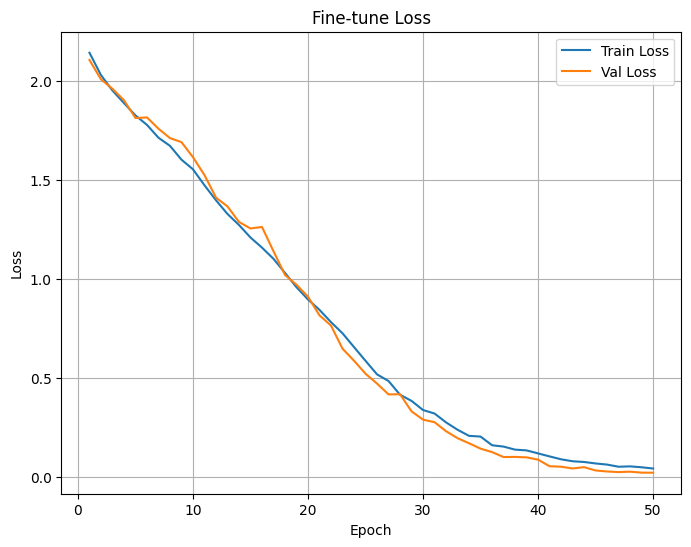

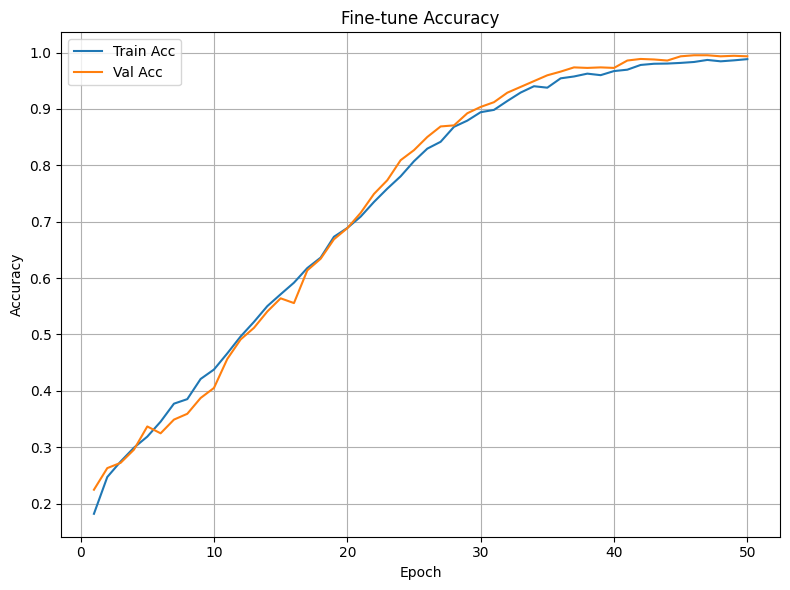

In [13]:
# Plot training curves
plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.title("Fine-tune Loss")
plt.grid(True)
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_accs)+1), train_accs, label='Train Acc')
plt.plot(range(1, len(val_accs)+1), val_accs, label='Val Acc')
plt.title("Fine-tune Accuracy")
plt.grid(True)
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
plt.tight_layout()
plt.show()


Evaluating on test set: 100%|██████████| 34/34 [00:09<00:00,  3.49it/s]


Test metrics:
  Accuracy:  0.9907
  Precision (macro): 0.9915
  Recall (macro):    0.9903
  F1 (macro):        0.9909

Classification report (per-class):
                                                precision    recall  f1-score   support

                                   1Gallstones       0.99      0.99      0.99       133
                  2Abdomen and retroperitoneum       0.99      0.97      0.98       117
                                3cholecystitis       0.97      0.96      0.97       114
      4Membranous and gangrenous cholecystitis       1.00      1.00      1.00       123
                                  5Perforation       0.99      1.00      1.00       106
              6Polyps and cholesterol crystals       1.00      1.00      1.00       102
                              7Adenomyomatosis       1.00      0.99      1.00       117
                                    8Carcinoma       0.98      1.00      0.99       159
9Various causes of gallbladder wall thickening       

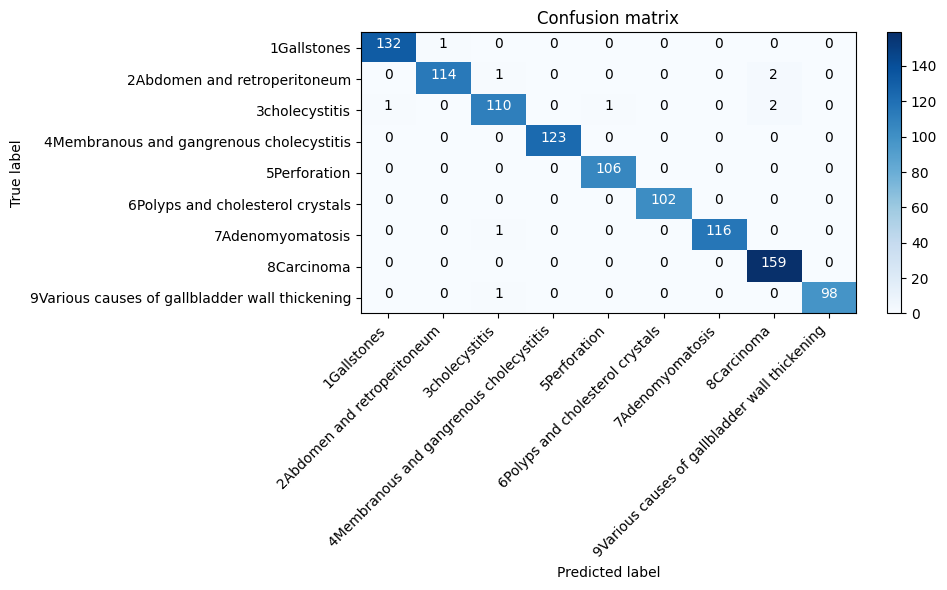

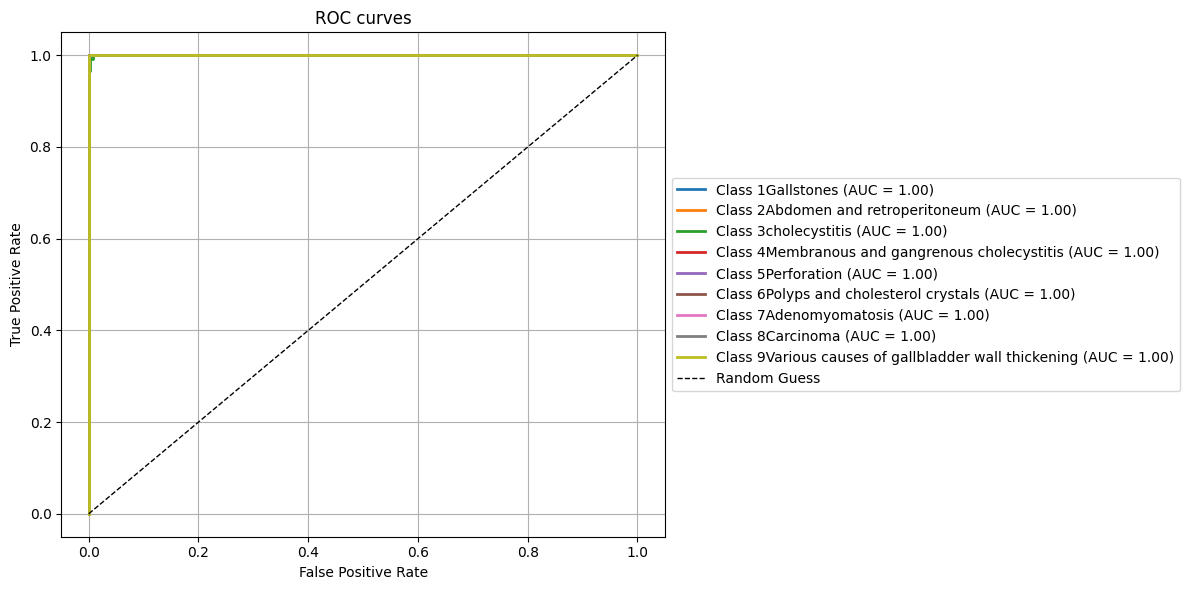

In [ ]:
# Evaluation on test set (load best weights)
checkpoint = torch.load(finetune_weights, map_location=device)
finetune_model.load_state_dict(checkpoint['model_state_dict'])
finetune_model.eval()

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating on test set"):
        imgs = imgs.to(device)
        outputs = finetune_model(imgs)  # B, num_classes
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_probs.append(probs)
        all_preds.append(preds)
        all_labels.append(labels.numpy())

all_probs = np.vstack(all_probs)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Overall metrics
acc = accuracy_score(all_labels, all_preds)
precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
print("Test metrics:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision (macro): {precision_macro:.4f}")
print(f"  Recall (macro):    {recall_macro:.4f}")
print(f"  F1 (macro):        {f1_macro:.4f}\n")

# Per-class report
print("Classification report (per-class):")
print(classification_report(all_labels, all_preds, target_names=classes, zero_division=0))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
# Plot confusion matrix
plt.figure(figsize=(10,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, aspect = 'auto')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()
plt.show()

# ROC curves (One-vs-Rest)
# Binarize labels
y_test_bin = label_binarize(all_labels, classes=range(num_classes))
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(12,6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--', lw=1, label = 'Random Guess')
plt.title("ROC curves")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.grid(True)

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

Evaluating on test set: 100%|██████████| 34/34 [00:09<00:00,  3.51it/s]


Test metrics:
  Accuracy:  0.9907
  Precision (weighted): 0.9907
  Recall (weighted):    0.9907
  F1 (weighted):        0.9906

Classification report (per-class):
                                                precision    recall  f1-score   support

                                   1Gallstones       0.99      0.99      0.99       133
                  2Abdomen and retroperitoneum       0.99      0.97      0.98       117
                                3cholecystitis       0.97      0.96      0.97       114
      4Membranous and gangrenous cholecystitis       1.00      1.00      1.00       123
                                  5Perforation       0.99      1.00      1.00       106
              6Polyps and cholesterol crystals       1.00      1.00      1.00       102
                              7Adenomyomatosis       1.00      0.99      1.00       117
                                    8Carcinoma       0.98      1.00      0.99       159
9Various causes of gallbladder wall thickeni

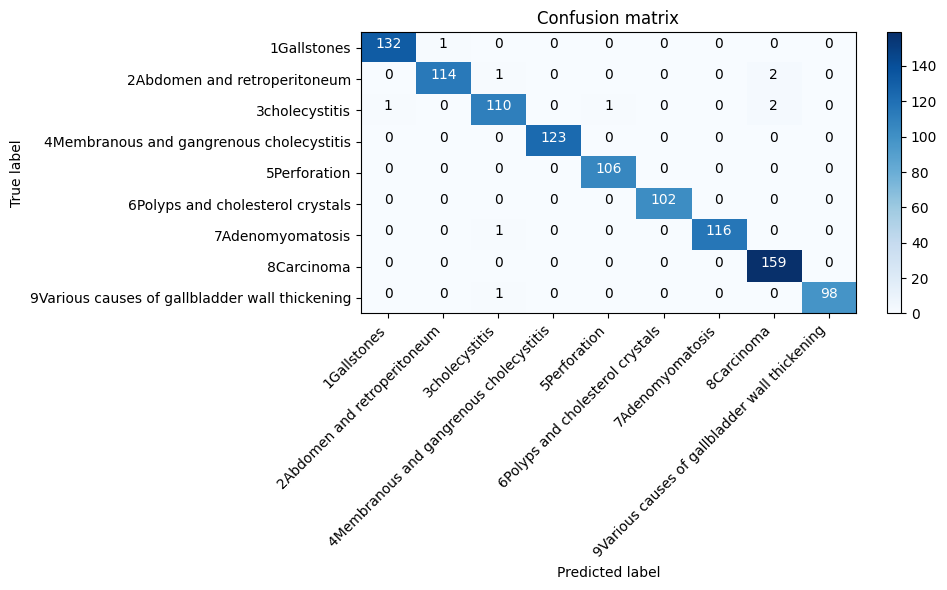

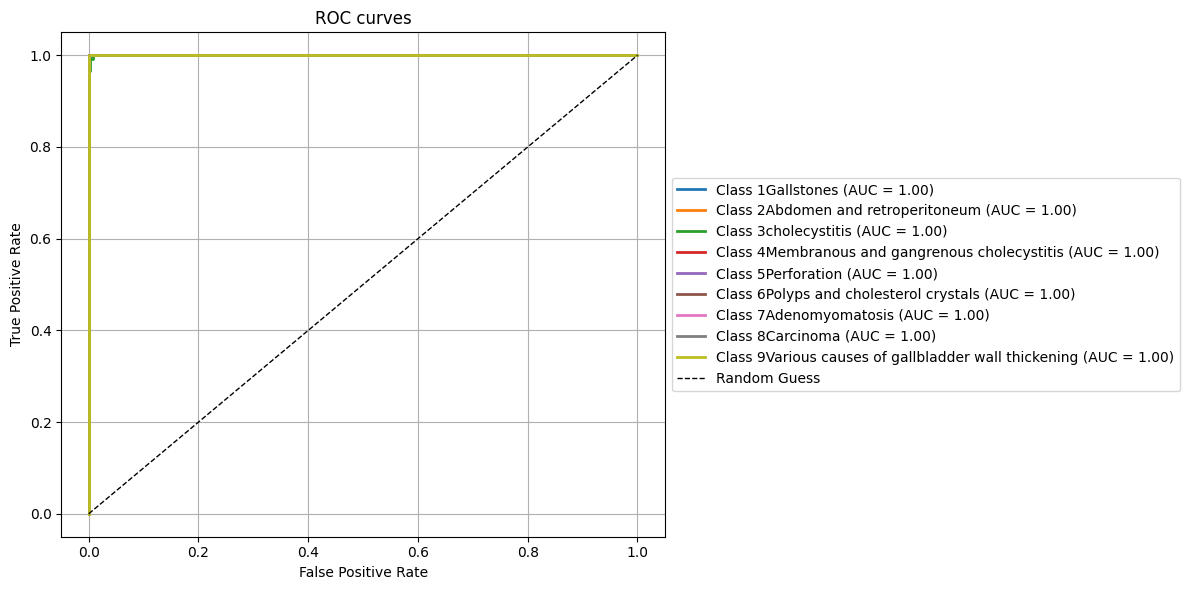

In [ ]:
# Evaluation on test set (load best weights)
checkpoint = torch.load(finetune_weights, map_location=device)
finetune_model.load_state_dict(checkpoint['model_state_dict'])
finetune_model.eval()

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating on test set"):
        imgs = imgs.to(device)
        outputs = finetune_model(imgs)  # B, num_classes
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_probs.append(probs)
        all_preds.append(preds)
        all_labels.append(labels.numpy())

all_probs = np.vstack(all_probs)
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Overall metrics
acc = accuracy_score(all_labels, all_preds)
precision_macro = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall_macro = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1_macro = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
print("Test metrics:")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision (weighted): {precision_macro:.4f}")
print(f"  Recall (weighted):    {recall_macro:.4f}")
print(f"  F1 (weighted):        {f1_macro:.4f}\n")

# Per-class report
print("Classification report (per-class):")
print(classification_report(all_labels, all_preds, target_names=classes, zero_division=0))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
# Plot confusion matrix
plt.figure(figsize=(10,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, aspect = 'auto')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()
plt.show()

# ROC curves (One-vs-Rest)
# Binarize labels
y_test_bin = label_binarize(all_labels, classes=range(num_classes))
fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# micro-average
fpr["weighted"], tpr["weighted"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

plt.figure(figsize=(12,6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--', lw=1, label = 'Random Guess')
plt.title("ROC curves")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.grid(True)

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# all_labels and all_preds are numpy arrays from test set
per_class_metrics = {}

for i, cls_name in enumerate(classes):
    # mask for this class
    idx = all_labels == i
    y_true_cls = all_labels[idx]
    y_pred_cls = all_preds[idx]
    
    # compute metrics
    acc = accuracy_score(y_true_cls, y_pred_cls)  
    prec = precision_score(y_true_cls, y_pred_cls, labels=[i], average='macro', zero_division=0)
    rec = recall_score(y_true_cls, y_pred_cls, labels=[i], average='macro', zero_division=0)
    f1 = f1_score(y_true_cls, y_pred_cls, labels=[i], average='macro', zero_division=0)
    
    per_class_metrics[cls_name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    }

# Print nicely
for cls_name, metrics in per_class_metrics.items():
    print(f"Class: {cls_name}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print()


Class: 1Gallstones
  accuracy: 0.9925
  precision: 1.0000
  recall: 0.9925
  f1_score: 0.9962

Class: 2Abdomen and retroperitoneum
  accuracy: 0.9744
  precision: 1.0000
  recall: 0.9744
  f1_score: 0.9870

Class: 3cholecystitis
  accuracy: 0.9649
  precision: 1.0000
  recall: 0.9649
  f1_score: 0.9821

Class: 4Membranous and gangrenous cholecystitis
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 5Perforation
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 6Polyps and cholesterol crystals
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 7Adenomyomatosis
  accuracy: 0.9915
  precision: 1.0000
  recall: 0.9915
  f1_score: 0.9957

Class: 8Carcinoma
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 9Various causes of gallbladder wall thickening
  accuracy: 0.9899
  precision: 1.0000
  recall: 0.9899
  f1_score: 0.9949



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# all_labels and all_preds are numpy arrays from test set
per_class_metrics = {}

for i, cls_name in enumerate(classes):
    # mask for this class
    idx = all_labels == i
    y_true_cls = all_labels[idx]
    y_pred_cls = all_preds[idx]
    
    # compute metrics
    acc = accuracy_score(y_true_cls, y_pred_cls)  
    prec = precision_score(y_true_cls, y_pred_cls, labels=[i], average='weighted', zero_division=0)
    rec = recall_score(y_true_cls, y_pred_cls, labels=[i], average='weighted', zero_division=0)
    f1 = f1_score(y_true_cls, y_pred_cls, labels=[i], average='weighted', zero_division=0)
    
    per_class_metrics[cls_name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    }

# Print nicely
for cls_name, metrics in per_class_metrics.items():
    print(f"Class: {cls_name}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print()


Class: 1Gallstones
  accuracy: 0.9925
  precision: 1.0000
  recall: 0.9925
  f1_score: 0.9962

Class: 2Abdomen and retroperitoneum
  accuracy: 0.9744
  precision: 1.0000
  recall: 0.9744
  f1_score: 0.9870

Class: 3cholecystitis
  accuracy: 0.9649
  precision: 1.0000
  recall: 0.9649
  f1_score: 0.9821

Class: 4Membranous and gangrenous cholecystitis
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 5Perforation
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 6Polyps and cholesterol crystals
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 7Adenomyomatosis
  accuracy: 0.9915
  precision: 1.0000
  recall: 0.9915
  f1_score: 0.9957

Class: 8Carcinoma
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1_score: 1.0000

Class: 9Various causes of gallbladder wall thickening
  accuracy: 0.9899
  precision: 1.0000
  recall: 0.9899
  f1_score: 0.9949

